# App Rating Prediction

##  DESCRIPTION


**Objective:** Develop a model to predict the rating for an app.

**Problem Statement:**
Google Play Store team is launching a new feature. The feature is intended to boost the visibility of those apps that are promising. The boost will manifest in multiple ways including higher priority in the recommendations sections ("Similar apps", "You might also like", "New and updated games"). The apps will also get a boost in visibility thru the search results.  The new feature will highlight newer apps that show a great deal of potential.

**Analysis:**
Identify the apps that will be featured and promoted by Google. An app's rating is a strong indicator of the goodness of the app. The goal is to predict which app's will have high ratings.

#  Data Collection

## Initialize environment/import libraries/import data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.cbook import boxplot_stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from termcolor import colored

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read in the data table
df_apps = pd.read_csv('/Users/samiai.masri/Documents/MastersProgram/6_Python/Project/googleplaystore.csv')

In [3]:
#Sample the dataframe
df_apps.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


# Data specification

In [4]:
#Variable:         Description

#App:              Application name
#Category:         Category to which the app belongs 
#Rating:           Overall user rating of the app
#Reviews:          Number of user reviews for the app
#Size:             Size of the app
#Installs:         Number of user downloads/installs for the app
#Type:             Paid or Free
#Price:            Price of the app
#Content Rating:   Age group the app is targeted at - Children / Mature 21+ / Adult
#Genres:           An app's composition/content (app's can belong to multiple genres 
#Last Updated:     Date when the app was last updated on Play Store
#Current Ver:      Current version of the app available on Play Store
#Android Ver:      Minimum required Android version

# Dataframe structure

In [5]:
df_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


# Missing values 

In [6]:
missing = df_apps.isnull().sum()
missing = missing[missing > 0]
print(missing)

Rating            1474
Type                 1
Content Rating       1
Current Ver          8
Android Ver          3
dtype: int64


In [7]:
df_apps.shape

(10841, 13)

In [8]:
#Drop rows with nulls in any columns
df_apps.dropna(axis=0, inplace = True)

#Reset the index since we dropped rows
df_apps.reset_index(drop=True,inplace=True)

In [9]:
df_apps.shape

(9360, 13)

# Format Features

## Size feature

In [10]:
#The 'Size' column has sizes in Kb as well as Mb. To analyze, convert these to numeric.
type('Size')

str

In [11]:
df_apps['Size'].value_counts().head()

Varies with device    1637
14M                    165
12M                    161
11M                    159
15M                    159
Name: Size, dtype: int64

In [12]:
#Varies with device is not a valid value for 'Size' feature.  Drop these records.
df_apps.drop(df_apps[df_apps['Size'] == 'Varies with device'].index, inplace = True)

In [13]:
df_apps.shape

(7723, 13)

In [14]:
#Extract numeric value from 'Size' column
df_apps["Size_Num"] = df_apps["Size"].str[:-1]  #We drop (slice off) the 'M' or 'k' from end of the string
df_apps.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_Num
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,19
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,14


In [15]:
#Extract size type (Mb or Kb) from 'Size' column
df_apps["Size_Type"] = df_apps["Size"].str[-1]  #We drop (slice off) the 'M' or 'k' from end of the string
df_apps.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_Num,Size_Type
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,19,M
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,14,M


In [16]:
df_apps['Size_Num'].value_counts().head(5)

14    166
12    161
11    159
15    159
13    157
Name: Size_Num, dtype: int64

In [17]:
#change the datatype for Size_Num from object to float
df_apps['Size_Num'] = df_apps['Size_Num'].astype(float)

In [18]:
df_apps.Size_Num.dtypes

dtype('float64')

In [19]:
df_apps.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_Num,Size_Type
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,19.0,M
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,14.0,M


In [20]:
#multiply those rows where Size is in Mb by 1000
df_apps.loc[df_apps.Size_Type == "M", "Size_Num"] = df_apps['Size_Num'] * 1000

In [21]:
df_apps.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_Num,Size_Type
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,19000.0,M
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,14000.0,M


In [22]:
#Drop Size and Rename Size_Num as Size, Drop Size_Type
df_apps.drop(['Size', 'Size_Type'], axis=1, inplace=True)
df_apps.rename(columns={"Size_Num": "Size"}, inplace=True)
df_apps.head(2)

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,19000.0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,14000.0


## Reviews feature 

In [23]:
#change the datatype for Reviews from object to int
df_apps['Reviews'] = df_apps['Reviews'].astype('float64')
df_apps.Reviews.dtypes

dtype('float64')

##  Installs feature

In [24]:
df_apps.Installs.value_counts().head(5)

1,000,000+     1301
100,000+       1037
10,000+         968
10,000,000+     825
1,000+          689
Name: Installs, dtype: int64

In [25]:
#Remove "," and "+" from Installs variable
df_apps["Installs"]= df_apps["Installs"].str.replace("[+,]","").astype('int64')

In [26]:
df_apps.Installs.dtypes

dtype('int64')

In [27]:
df_apps["Installs"].map('{:,d}'.format).value_counts().sort_values(ascending=False).head(5)

1,000,000     1301
100,000       1037
10,000         968
10,000,000     825
1,000          689
Name: Installs, dtype: int64

## Price feature 

In [28]:
df_apps.Price.value_counts().head(5)

0        7146
$0.99     105
$2.99     101
$4.99      63
$1.99      53
Name: Price, dtype: int64

In [29]:
#Remove "$" from Price variable & convert it to float
df_apps["Price"]= df_apps["Price"].str.replace("[$]","").astype(float)

In [30]:
df_apps.Price.value_counts().head(5)

0.00    7146
0.99     105
2.99     101
4.99      63
1.99      53
Name: Price, dtype: int64

In [31]:
df_apps.Price.dtypes

dtype('float64')

# Sanity checks 

## Rating feature 

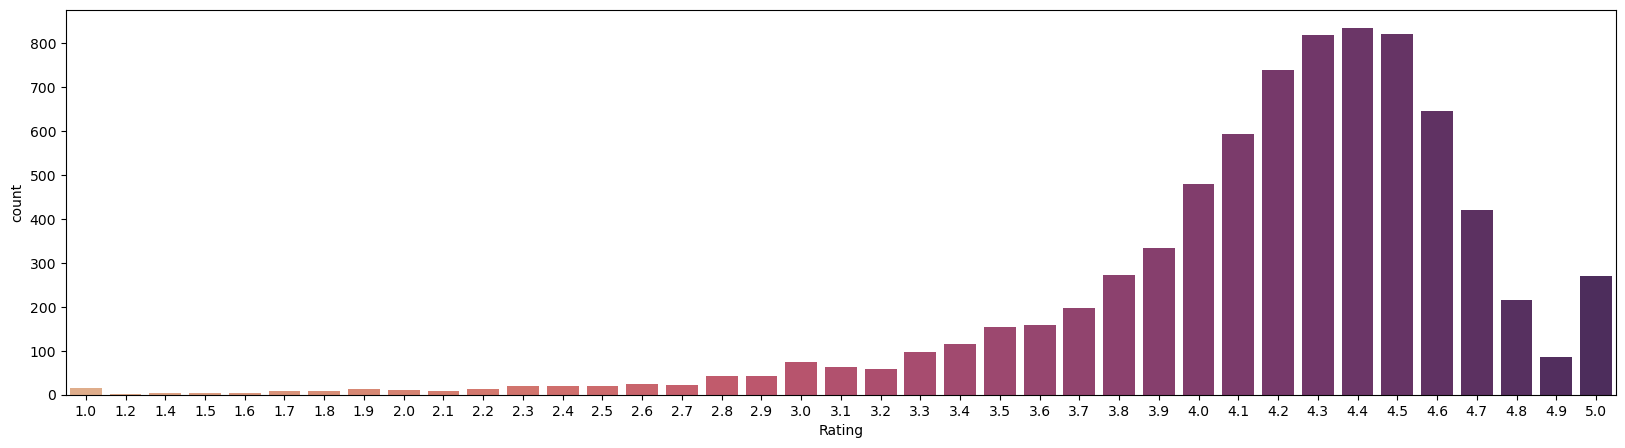

In [32]:
#Average rating should be between 1 and 5, drop rows outside this range
plt.style.use('default')
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Rating", data=df_apps, palette="flare")
plt.show()

In [33]:
# Average rating should be between 1 and 5, drop rows outside this range.
df_filtered_Invalid_Rating = df_apps.loc[(df_apps['Rating'] < 1.0) | (df_apps['Rating'] > 5.0)]
print("Records with invalid Ratings:" ,df_filtered_Invalid_Rating.Rating.count())
print("Shape of dataframe :", df_apps.shape)

Records with invalid Ratings: 0
Shape of dataframe : (7723, 13)


In [34]:
df_apps.drop(((df_apps[df_apps['Rating'] < 1.0]) |(df_apps[df_apps['Rating'] > 5.0])).index, inplace = True)
print("New shape of dataframe :", df_apps.shape)

New shape of dataframe : (7723, 13)


## Reviews feature

In [35]:
# Number of Reviews should not be greater than Installs.  Drop Records where Reviews > Installs.
df_filtered_Invalid_Review = df_apps[df_apps['Reviews'] > df_apps['Installs']]
print("Records with invalid Reviews:" ,df_filtered_Invalid_Review.Reviews.count())
df_filtered_Invalid_Review
df_apps.shape

Records with invalid Reviews: 6


(7723, 13)

In [36]:
# Number of Reviews should not be greater than Installs.  Drop Records where Reviews > Installs.
df_apps.drop(df_apps[df_apps['Reviews'] > df_apps['Installs']].index, inplace = True)

In [37]:
#New dataframe after dropping the invalid records
df_apps.shape

(7717, 13)

## Price feature

In [38]:
#For Free apps the Price should be 0.  Drop the invalid records.
df_apps[["Price","Type"]].value_counts().sort_index()

Price   Type
0.00    Free    7142
0.99    Paid     104
1.00    Paid       2
1.20    Paid       1
1.29    Paid       1
                ... 
299.99  Paid       1
379.99  Paid       1
389.99  Paid       1
399.99  Paid      11
400.00  Paid       1
Length: 68, dtype: int64

In [39]:
#For Free apps the Price should be 0.  Drop the invalid records.
df_filtered_Invalid_Price= df_apps.loc[(df_apps['Price'] != 0) & (df_apps['Type'] == "Free")]
print("Records with invalid Pricing:" ,df_filtered_Invalid_Price.Price.count())

Records with invalid Pricing: 0


In [40]:
#Drop Invalid Price records
df_apps.drop(df_apps.loc[(df_apps['Price'] != 0) & (df_apps['Type'] == "Free")].index, inplace = True)

In [41]:
df_apps.shape

(7717, 13)

# Performing Univariate Analysis 

## Numeric features 

In [42]:
#Performing Univariate Analysis - Box Plots for Numeric Features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_var = []         #initialize 
for each in df_apps.columns: #for each column that is numeric
    if df_apps[each].dtypes in numerics:
        numeric_var.append(each)

print(numeric_var)

['Rating', 'Reviews', 'Installs', 'Price', 'Size']


### Boxplot Numeric features 

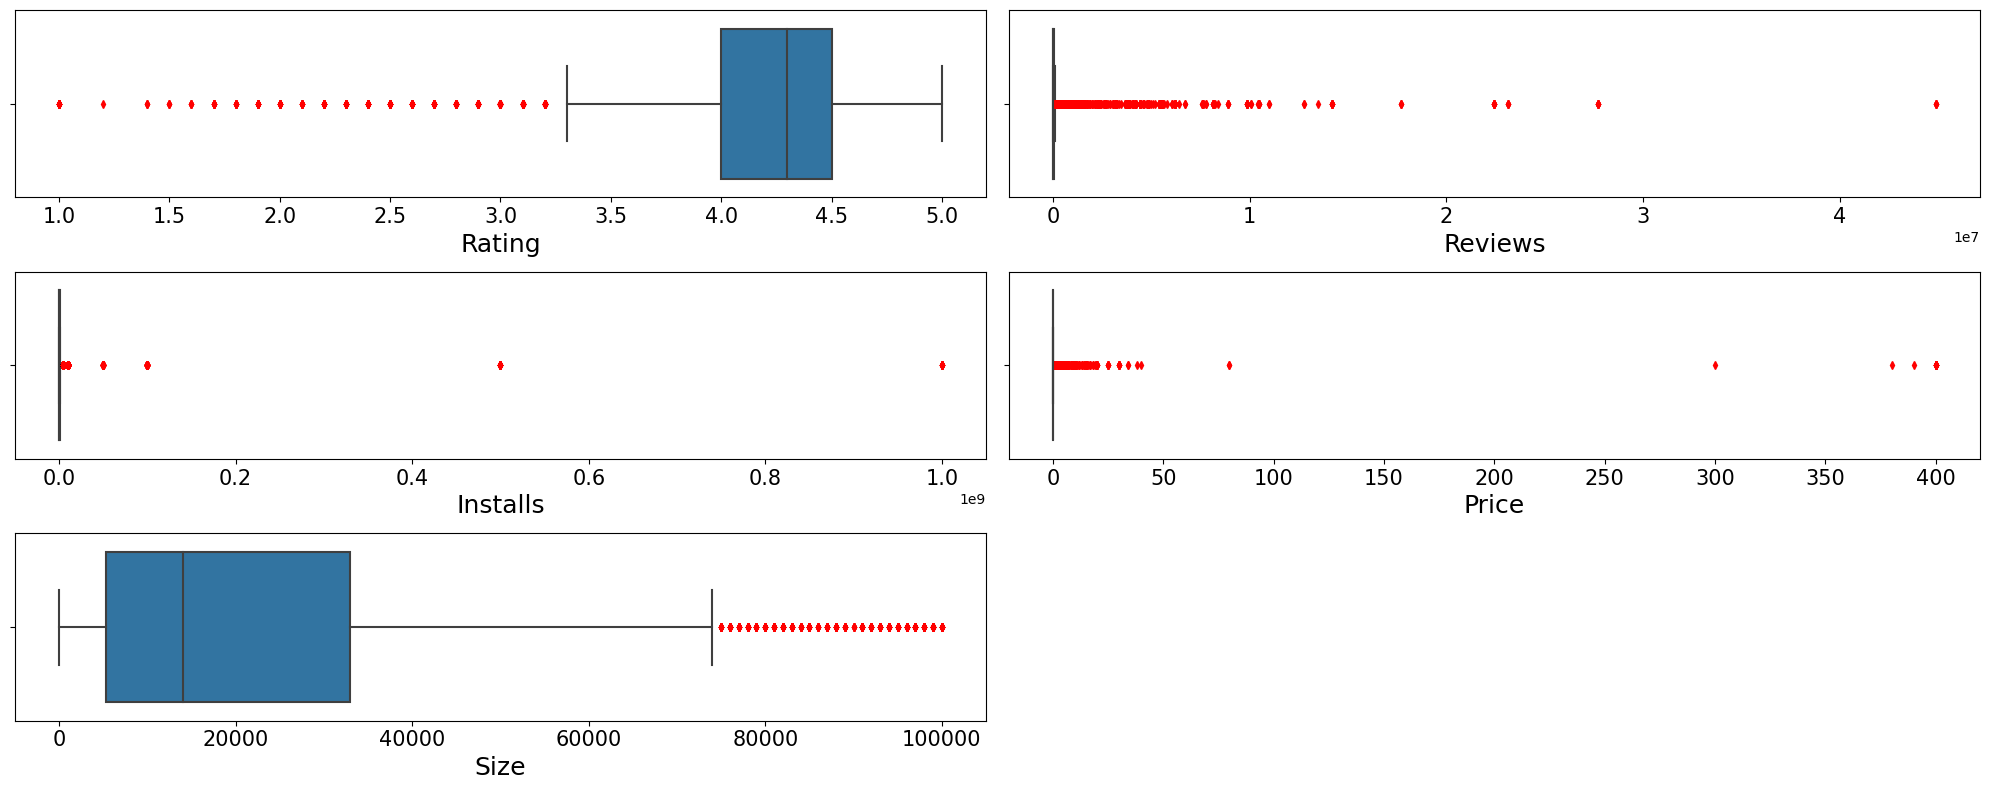

In [43]:
#BoxPlot for Numeric Columns including Price:

flierprops = dict(marker='d', markerfacecolor='r', markersize=4, linestyle='none', markeredgecolor='r')

plt.figure(figsize=(20,8))
plt.style.use('default')

for i in enumerate(numeric_var):
    plt.subplot(3,2,i[0]+1)
    ax=sns.boxplot(data=df_apps, x=i[1], orient='v', flierprops=flierprops)
    plt.xlabel(i[1], fontsize=18)
    ax.tick_params(axis='x', labelsize=15 )

plt.tight_layout()
plt.show()

### Histogram Numeric features 

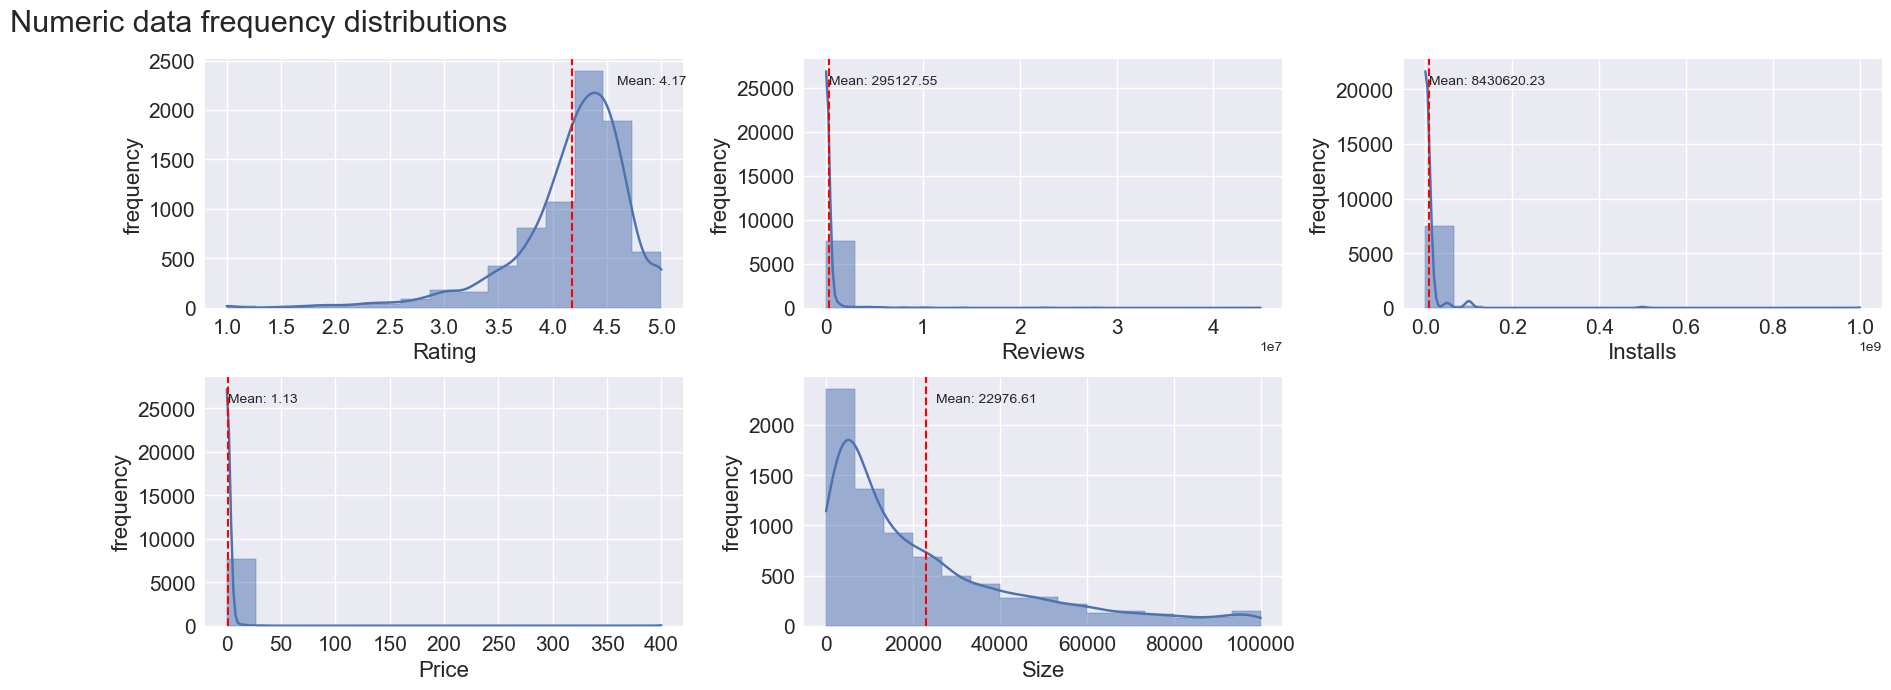

In [44]:
fig=plt.figure(figsize=(18,7))
plt.style.use('seaborn')
fig.suptitle('Numeric data frequency distributions', fontsize=22, x=0.09) 

for i in enumerate(numeric_var):
    plt.subplot(2,3,i[0]+1)
    ax=sns.histplot(data=df_apps, x=i[1],element='step',palette=['darkslateblue'],bins=15, kde=True)
    plt.xlabel(i[1],  fontsize=16)
    plt.ylabel("frequency", fontsize=16)
    plt.axvline(x=df_apps[i[1]].mean(),ls='--', lw=1.5, c='r')
    plt.setp(ax.get_xticklabels(), fontsize=15)
    plt.setp(ax.get_yticklabels(), fontsize=15)
    min_ylim, max_ylim = plt.ylim()
    plt.text(df_apps[i[1]].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df_apps[i[1]].mean()))

plt.tight_layout()
plt.show()


### Overall summary statistics - Numeric features 

In [45]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.transpose(df_apps.describe())

,count,mean,std,min,25%,50%,75%,max
Rating,7717.00,4.17,0.54,1.00,4.00,4.30,4.50,5.00
Reviews,7717.00,295127.55,1864639.61,1.00,109.00,2351.00,39109.00,44893888.00
Installs,7717.00,8430620.23,50176362.80,5.00,10000.00,100000.00,1000000.00,1000000000.00
Price,7717.00,1.13,17.41,0.00,0.00,0.00,0.00,400.00
Size,7717.00,22976.61,23456.77,8.50,5300.00,14000.00,33000.00,100000.00


## Price feature outliers 

In [46]:
print("Percentiles")
df_apps['Price'].quantile([0.1, .25, .50, .70, .90, .95, .99])

Percentiles


0.10   0.00
0.25   0.00
0.50   0.00
0.70   0.00
0.90   0.00
0.95   1.99
0.99   9.99
Name: Price, dtype: float64

In [47]:
df_filtered_Price_gt999= df_apps.loc[(df_apps['Price'] > 9.99)]
print("Count of apps with prices greater $9.99 :" ,df_filtered_Price_gt999.Price.count())

Count of apps with prices greater $9.99 : 71


**Price feature observations:** Box plot and histogram for "Price" feature indicates several values that are outliers in the data.  The price of an app has an average value of $1.13, with 90% of the app prices costing \\$0.00. Overall, 99.0% of the prices for the apps is not more than \\$9.99. There are at least 71 apps (potential outliers) with prices greater than \\$9.99.

## Reviews feature outliers 

In [48]:
print("Percentiles")
df_apps['Reviews'].quantile([0.1, .25, .50, .70, .90, .95, .99])

Percentiles


0.10        14.00
0.25       109.00
0.50      2351.00
0.70     24128.60
0.90    264471.20
0.95    857356.60
0.99   6211914.28
Name: Reviews, dtype: float64

In [49]:
df_filtered_Reviews_gt1MM= df_apps.loc[(df_apps['Reviews'] > 1000000)]
print("Count of apps with Reviews greater 1MM :" ,df_filtered_Reviews_gt1MM.Reviews.count())

Count of apps with Reviews greater 1MM : 339


**Reviews feature observations:** Box plot and histogram for "Reviews" feature indicates several values that are outliers in the data.  The average number of Reviews submitted for an app is ~295K. Overall, 95.0% of the apps have ~857K Reviews or less. 

## Rating feature distribution 

In [50]:
print("Percentiles")
df_apps['Rating'].quantile([0.1, .25, .50, .70, .90, .95, .99])

Percentiles


0.10   3.50
0.25   4.00
0.50   4.30
0.70   4.50
0.90   4.70
0.95   4.80
0.99   5.00
Name: Rating, dtype: float64

In [51]:
df_filtered_Rating_lt35= df_apps.loc[(df_apps['Rating'] < 3.5)]
print("Count of apps with a rating less than 3.5 :" ,df_filtered_Rating_lt35.Rating.count())

Count of apps with a rating less than 3.5 : 686


**Rating feature, distribution observations:** The average rating score for an app is 4.17.  The data distribution for app rating scores is negatively skewed. This is apparent in the histogram for "Rating" feature as well as the box plot. The negative skew indicates that the feature is skewed and the tail of the distribution is longer towards the left hand side of the curve. We would expect that the outliers in the data would lie in this area to the left. Less than 10% of the apps have scores below 3.5.

## Size feature distribution 

In [52]:
print("Percentiles")
df_apps['Size'].quantile([0.1, .25, .50, .70, .90, .95, .99])

Percentiles


0.10    2500.00
0.25    5300.00
0.50   14000.00
0.70   27000.00
0.90   59000.00
0.95   76000.00
0.99   97000.00
Name: Size, dtype: float64

In [53]:
df_filtered_Size_gt76= df_apps.loc[(df_apps['Size'] > 76000)]
print("Count of apps with a Size greater than 76K:" ,df_filtered_Size_gt76.Size.count())

Count of apps with a Size greater than 76K: 374


**Size feature, distribution observations:** The average size for an app is ~23K.  The data distribution for an apps size is positively skewed. This is apparent in the histogram for "Size" feature as well as the box plot. The positive skew indicates that the feature is skewed and the tail of the distribution is longer towards the right hand side of the curve. We would expect that the outliers in the data would lie in this area to the right. Approximately 5% of the data on app sizes as greater than 76K.

# Outliers treatment

## Price feature 

**Handling over-priced apps:**  App price greater >= \\$200 should be excluded from app prediction analysis.  These apps may be dummy data or junk apps.

In [54]:
df_filtered_Invalid_Price2 = df_apps.loc[(df_apps['Price'] >= 200.0)]
print("Records with Price greater than $200: " ,df_filtered_Invalid_Price2.Price.count())
print("Shape of dataframe :", df_apps.shape)

Records with Price greater than $200:  15
Shape of dataframe : (7717, 13)


In [55]:
df_filtered_Invalid_Price2.head(5)

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size
4036,most expensive app (H),FAMILY,4.30,6.00,100,Paid,399.99,Everyone,Entertainment,"July 16, 2018",1.0,7.0 and up,1500.00
4189,💎 I'm rich,LIFESTYLE,3.80,718.00,10000,Paid,399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up,26000.00
4194,I'm Rich - Trump Edition,LIFESTYLE,3.60,275.00,10000,Paid,400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up,7300.00
5042,I am rich,LIFESTYLE,3.80,3547.00,100000,Paid,399.99,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up,1800.00
5045,I am Rich Plus,FAMILY,4.00,856.00,10000,Paid,399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up,8700.00


In [56]:
#Drop over-priced apps
df_apps.drop(df_apps.loc[(df_apps['Price'] >= 200)].index, inplace = True)

In [57]:
df_apps.shape

(7702, 13)

## Reviews feature 

In [58]:
#Reviews: Apps with over 2 million reviews will skew the data.  Drop these apps.
df_filtered_Invalid_Review2 = df_apps.loc[(df_apps['Reviews'] > 2000000)]
print("Records with Reviews greater than 2MM: " ,df_filtered_Invalid_Review2.Reviews.count())
print("Shape of dataframe :", df_apps.shape)

Records with Reviews greater than 2MM:  219
Shape of dataframe : (7702, 13)


In [59]:
#Drop apps with Reviews totalling more than 2MM
df_apps.drop(df_apps.loc[(df_apps['Reviews'] > 2000000)].index, inplace = True)
df_apps.shape

(7483, 13)

## Installs feature 

In [60]:
#Installs: Drop the apps with outliers for # of installs.
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.transpose(df_apps["Installs"].describe())

count         7483.00
mean       3947464.54
std       27818305.32
min              5.00
25%          10000.00
50%         100000.00
75%        1000000.00
max     1000000000.00
Name: Installs, dtype: float64

In [61]:
df_apps['Installs'].quantile([0.1, .25, .50, .70, .90, .95, .99])

0.10       1000.00
0.25      10000.00
0.50     100000.00
0.70    1000000.00
0.90   10000000.00
0.95   10000000.00
0.99   50000000.00
Name: Installs, dtype: float64

**Find Outliers Using Tukey Method and IQR**


Tukey’s rule states that outliers are values more than 1.5 times the interquartile (IQR) range from the 
quartiles.  That is data points below Q1 − 1.5IQR, or above Q3 + 1.5IQR where IQR = Q3 - Q1.

Seaborn boxplot uses the IQR range to map out the outliers. The whiskers = Q1 - 1.5 x IQR (on the left) and Q3 + 1.5 x IQR (on the right).  Any value outside of the whiskers is called the outliers.  We will use this technique to identify the outliers in our dataframe for the Installs feature.

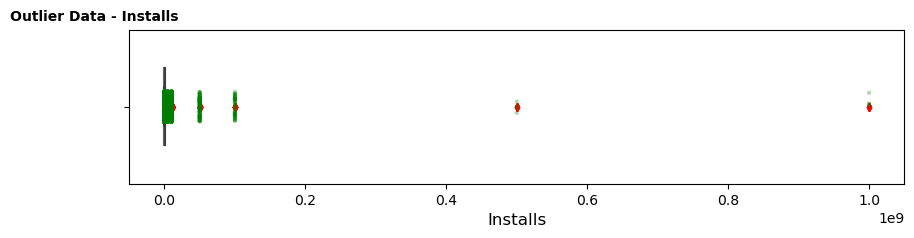

In [62]:
plt.style.use('default')

for i in enumerate(numeric_var[2:3]):
    
    title=i[1]
    fig, (ax1) = plt.subplots(1,1,figsize=(10,2))
    fig.suptitle('Outlier Data' + " - " + title[0].upper() + title[1:], fontsize=10, fontweight="bold", x=0.09)
    #boxplot/stripplot
    sns.boxplot(x=i[1], data=df_apps, width=0.5,boxprops=dict(alpha=0.8), flierprops=flierprops, ax=ax1)
    sns.stripplot(x=i[1],data=df_apps, jitter=True, alpha=0.3, color='green', s=3, ax=ax1)
    plt.setp(ax1.get_xticklabels(), fontsize=10)
    ax1.set_xlabel(i[1], fontsize=12)
    
plt.show()

Let us calculate Q1, Q3 and IQR:

In [63]:
#calculte Q1, Q3 and IQR
Q1 = df_apps.Installs.quantile(0.25)
Q3 = df_apps.Installs.quantile(0.75)
print("75% (3rd quantile value:) " + str(Q3))
print("25% (1st quantile value:) " + str(Q1))
print ("Median: " + str(df_apps.Installs.median()))
IQR = Q3 - Q1
print("Inner Quartile Range (IQR) = Q3-Q1 : " + str(IQR))

75% (3rd quantile value:) 1000000.0
25% (1st quantile value:) 10000.0
Median: 100000.0
Inner Quartile Range (IQR) = Q3-Q1 : 990000.0


Calculate the upper and lower limits. Any value below the lower limit and any value above the upper limit
are outliers.

In [64]:
# Calculate the upper and lower limits  (any value below the lower limit and any value above the upper limit
# are outliers)

Lower_L = Q1 - 1.5*IQR
Upper_L = Q3 + 1.5*IQR

print("Lower Limit: " + str(Lower_L))

print("Upper Limit: " + str(Upper_L))

Lower Limit: -1475000.0
Upper Limit: 2485000.0


List of Install outliers:

In [65]:
#Identify the outliers
installs_outliers = df_apps.loc[(df_apps['Installs'] > Upper_L) | (df_apps['Installs'] < Lower_L)]
unique_installs_outliers = installs_outliers["Installs"].unique()
unique_installs_outliers


array([   5000000,   50000000,   10000000,  100000000,  500000000,
       1000000000])

Using boxplot_stats we can confirm the outliers data we calculated above:

In [66]:
#using boxplot_stats we can confirm the outlier data we calculated above 
installs_fliers = boxplot_stats(df_apps.Installs).pop(0)['fliers']
np.unique(installs_fliers)

array([   5000000,   10000000,   50000000,  100000000,  500000000,
       1000000000])

In [67]:
#select the max value any intstall can have (this will be the threshold)
maxvalue_threshold = installs_fliers.min() #take the lowest value in outliers to treat it as the threshold max
maxvalue_threshold

5000000

In [68]:
df_filtered_Outlier_Installs = df_apps.loc[(df_apps['Installs'] > 5000000)]
print("Records with Installs greater than 5MM: " ,df_filtered_Outlier_Installs.Installs.count())
print("Shape of dataframe :", df_apps.shape)

Records with Installs greater than 5MM:  994
Shape of dataframe : (7483, 13)


In [69]:
#Drop those apps with installs above threshold
df_apps.drop(df_apps.loc[(df_apps['Installs'] > maxvalue_threshold)].index, inplace = True)
df_apps.shape

(6489, 13)

# Bivariate Analysis 

Study the predicator features and how they relate to the target feature (Rating). Make scatter plots for the Numeric features and box plots for the category features to assess the relationship between target variable (rating) and the independent features in our dataset.

In [70]:
df_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6489 entries, 0 to 9357
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             6489 non-null   object 
 1   Category        6489 non-null   object 
 2   Rating          6489 non-null   float64
 3   Reviews         6489 non-null   float64
 4   Installs        6489 non-null   int64  
 5   Type            6489 non-null   object 
 6   Price           6489 non-null   float64
 7   Content Rating  6489 non-null   object 
 8   Genres          6489 non-null   object 
 9   Last Updated    6489 non-null   object 
 10  Current Ver     6489 non-null   object 
 11  Android Ver     6489 non-null   object 
 12  Size            6489 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 709.7+ KB


In [71]:
#Drop columns not applicable to the analysis
#Last Updated , Current Ver, Android Ver, App
df_apps.drop(['App','Last Updated', 'Current Ver', 'Android Ver'], axis=1, inplace=True)

In [72]:
df_apps.dtypes

Category           object
Rating            float64
Reviews           float64
Installs            int64
Type               object
Price             float64
Content Rating     object
Genres             object
Size              float64
dtype: object

In [73]:
#Bin size groups
df_apps['size_groups'] = pd.cut(x=df_apps['Size'], bins=3, labels=["small", "medium", "large"]).astype("object")

In [74]:
#Bin reviews groups
df_apps['reviews_groups'] = pd.cut(x=df_apps['Reviews'], bins=3, labels=["low", "medium", "high"]).astype("object")

In [75]:
#Performing Univariate Analysis - identify character features
category = ['object']
category_var = []            #initialize 
for each in df_apps.columns: #for each column that is object
    if df_apps[each].dtypes in category:
        category_var.append(each)

print(category_var)

['Category', 'Type', 'Content Rating', 'Genres', 'size_groups', 'reviews_groups']


## Rating vs Price

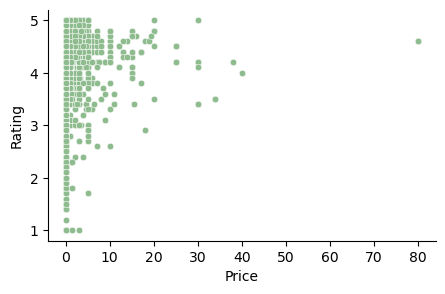

In [76]:
plt.figure(figsize=(5,3))
a = sns.scatterplot(x="Price", y="Rating", color=['darkseagreen'], s=22, data=df_apps)
sns.despine()

plt.show()

In [77]:
y=df_apps['Type'].count()

for i in enumerate(category_var[1:2]):

    print(colored(("Summary Statistics feature - " + i[1] + ":"),'green',attrs=['bold']))
    print("")
    def my_agg(x):
        names = {
            'total_apps'   : x[i[1]].count(),
            '%_of_apps'    : (x[i[1]].count()/y)*100,
            'mean_price'   : x['Price'].mean(),
            'mean_rating'  : x['Rating'].mean(),
            'mean_reviews' : x['Reviews'].mean(),
            'mean_installs': x['Installs'].mean(),
            'mean_size'    : x['Size'].mean()
        }
        
        return pd.Series(names, index=['total_apps','%_of_apps','mean_price','mean_rating','mean_reviews',
                                       'mean_installs','mean_size'])
    stats = df_apps.groupby([i[1]]).apply(my_agg).round(2)
    print(np.transpose(stats))

Summary Statistics feature - Type:

Type               Free     Paid
total_apps      5930.00   559.00
%_of_apps         91.39     8.61
mean_price         0.00     5.08
mean_rating        4.13     4.26
mean_reviews   17813.49  6520.25
mean_installs 728744.93 66940.57
mean_size      20221.04 20959.45


In [78]:
# Measuring correlation between Price and Rating
df_apps[['Price','Rating']].corr()

,Price,Rating
Price,1.00,0.03
Rating,0.03,1.00


**Rating vs Price Observations:** From the scatter plot we can observe a non-linear pattern in the data between Price and Rating.  There appears to be little correlation between the price of an app and its rating score.  Apps that are free of charge and apps that require a paid subscription generally rate the same. Paid apps only slightly out-score free apps by 0.13%. The mean rating for free apps is 4.13, while the mean rating score for paid apps is 4.26. 

## Rating vs Size

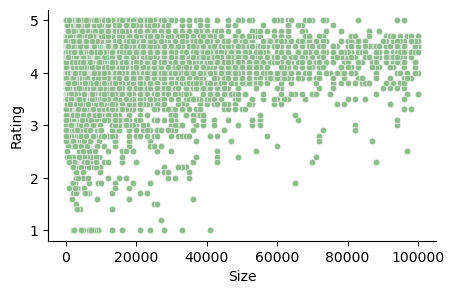

In [79]:
plt.figure(figsize=(5,3))
a = sns.scatterplot(x="Size", y="Rating", color=['darkseagreen'], s=22, data=df_apps)
sns.despine()

plt.show()

In [80]:
y=df_apps['size_groups'].count()

for i in enumerate(category_var[4:5]):

    print(colored(("Summary Statistics feature - " + i[1] + ":"),'green',attrs=['bold']))
    print("")
    def my_agg(x):
        names = {
            'total_apps'   : x[i[1]].count(),
            '%_of_apps'    : (x[i[1]].count()/y)*100,
            'mean_price'   : x['Price'].mean(),
            'mean_rating'  : x['Rating'].mean(),
            'mean_reviews' : x['Reviews'].mean(),
            'mean_installs': x['Installs'].mean(),
            'mean_size'    : x['Size'].mean()
        }
        
        return pd.Series(names, index=['total_apps','%_of_apps','mean_price','mean_rating','mean_reviews',
                                       'mean_installs','mean_size'])
    stats = df_apps.groupby([i[1]]).apply(my_agg).round(2).sort_values(by=['total_apps'],ascending=False)
    print(np.transpose(stats))

Summary Statistics feature - size_groups:

size_groups       small     medium      large
total_apps      5161.00     982.00     346.00
%_of_apps         79.53      15.13       5.33
mean_price         0.42       0.46       0.61
mean_rating        4.14       4.16       4.22
mean_reviews   12765.24   27981.89   46009.20
mean_installs 565264.09 1003658.39 1317793.87
mean_size      11093.60   46405.30   83245.66


In [81]:
# Measuring correlation between Size and Rating
df_apps[['Size','Rating']].corr()

,Size,Rating
Size,1.00,0.04
Rating,0.04,1.00


**Rating vs Size Observations:** From the scatter plot we can observe a non-linear pattern in the data between Size and Rating.  There appears to be little correlation between the size of an app and its rating score.  After binning the Size feature into groups, we can note that there is relatively little change in rating score between the apps.  Small sized apps which make-up nearly 80% of the apps in total, had a rating of 4.14, while medium and large sized apps rated 4.16 and 4.22, respectively.

## Rating vs Reviews

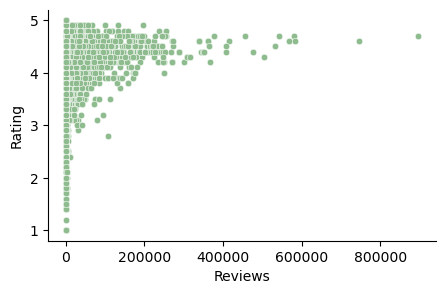

In [82]:
plt.figure(figsize=(5,3))
a = sns.scatterplot(x="Reviews", y="Rating", color=['darkseagreen'], s=22, data=df_apps)
sns.despine()

plt.show()

In [83]:
y=df_apps['reviews_groups'].count()

for i in enumerate(category_var[5:6]):

    print(colored(("Summary Statistics feature - " + i[1] + ":"),'green',attrs=['bold']))
    print("")
    def my_agg(x):
        names = {
            'total_apps'   : x[i[1]].count(),
            '%_of_apps'    : (x[i[1]].count()/y)*100,
            'mean_price'   : x['Price'].mean(),
            'mean_rating'  : x['Rating'].mean(),
            'mean_reviews' : x['Reviews'].mean(),
            'mean_installs': x['Installs'].mean(),
            'mean_size'    : x['Size'].mean()
        }
        
        return pd.Series(names, index=['total_apps','%_of_apps','mean_price','mean_rating','mean_reviews',
                                       'mean_installs','mean_size'])
    stats = df_apps.groupby([i[1]]).apply(my_agg).round(2).sort_values(by=['total_apps'],ascending=False)
    print(np.transpose(stats))

Summary Statistics feature - reviews_groups:

reviews_groups       low     medium       high
total_apps       6460.00      27.00       2.00
%_of_apps          99.55       0.42       0.03
mean_price          0.44       0.26       0.00
mean_rating         4.14       4.49       4.65
mean_reviews    14969.46  404973.11  820901.00
mean_installs  654160.56 4555555.56 5000000.00
mean_size       20180.59   43366.67   44800.00


In [84]:
# Measuring correlation between Size and Rating
df_apps[['Reviews','Rating']].corr()

,Reviews,Rating
Reviews,1.00,0.13
Rating,0.13,1.00


In [85]:
#df_apps.to_excel(r'/Users/samiai.masri/Documents/MastersProgram/6_Python/Project/reviews.xlsx', index = False)

**Rating vs Reviews Observations:** From the scatter plot we can observe a non-linear pattern in the data between number of Reviews and Rating.  There appears to be little correlation between the the number of reviews an app receives and its rating score.  However, the scatter graph does suggest that apps with a higher number of reviews generally tend to have high rating scores.  On average, apps with a high number of reviews received a rating score of 4.65%, while those apps with a low number of reviews scored on average 4.14; that is a 0.51% difference in scores.

## Rating vs. Content Rating

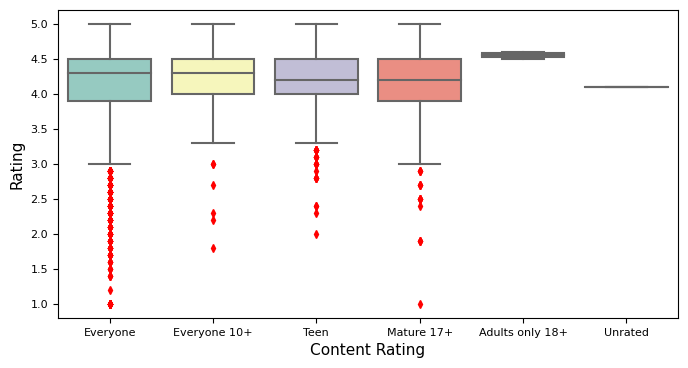

In [86]:
#BoxPlot for Rating vs Content Rating:
plt.figure(figsize=(8,4))

ax=sns.boxplot(data=df_apps, x='Content Rating', y='Rating', orient='v',  palette="Set3", flierprops=flierprops)
plt.xlabel("Content Rating", size=11)
plt.ylabel("Rating", size=11)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

In [87]:
y=df_apps['Content Rating'].count()

for i in enumerate(category_var[2:3]):

    print(colored(("Summary Statistics feature - " + i[1] + ":"),'green',attrs=['bold']))
    print("")
    def my_agg(x):
        names = {
            'total_apps'   : x[i[1]].count(),
            '%_of_apps'    : (x[i[1]].count()/y)*100,
            'mean_price'   : x['Price'].mean(),
            'mean_rating'  : x['Rating'].mean(),
            'mean_reviews' : x['Reviews'].mean(),
            'mean_installs': x['Installs'].mean(),
            'mean_size'    : x['Size'].mean()
        }
        
        return pd.Series(names, index=['total_apps','%_of_apps','mean_price','mean_rating','mean_reviews',
                                       'mean_installs','mean_size'])
    stats = df_apps.groupby([i[1]]).apply(my_agg).round(2).sort_values(by=['total_apps'],ascending=False)
    print(np.transpose(stats))

Summary Statistics feature - Content Rating:

Content Rating  Everyone       Teen  Mature 17+  Everyone 10+  \
total_apps       5296.00     666.00      311.00        213.00   
%_of_apps          81.62      10.26        4.79          3.28   
mean_price          0.45       0.33        0.32          0.66   
mean_rating         4.14       4.19        4.07          4.20   
mean_reviews    13478.20   35812.73    19727.33      36791.57   
mean_installs  613654.45 1078295.95   650234.50     878146.53   
mean_size       18284.77   30075.37    24212.88      33700.60   

Content Rating  Adults only 18+  Unrated  
total_apps                 2.00     1.00  
%_of_apps                  0.03     0.02  
mean_price                 0.00     0.00  
mean_rating                4.55     4.10  
mean_reviews           37011.00  1186.00  
mean_installs         750000.00 50000.00  
mean_size              22950.00  6400.00  


**Rating vs Content Rating Observations:** From the boxplot we can observe an overlap in rating score among Content Rating feature.  This implies the rating scores are relatively comparable to each other.  The "Adults only 18+" Content Rating draws a rating score that is slightly higher than the other groups.  Note, however, there appear to be potential outliers in the data that may be skewing the mean rating scores for the Content Rating groups. 

## Rating vs Category 

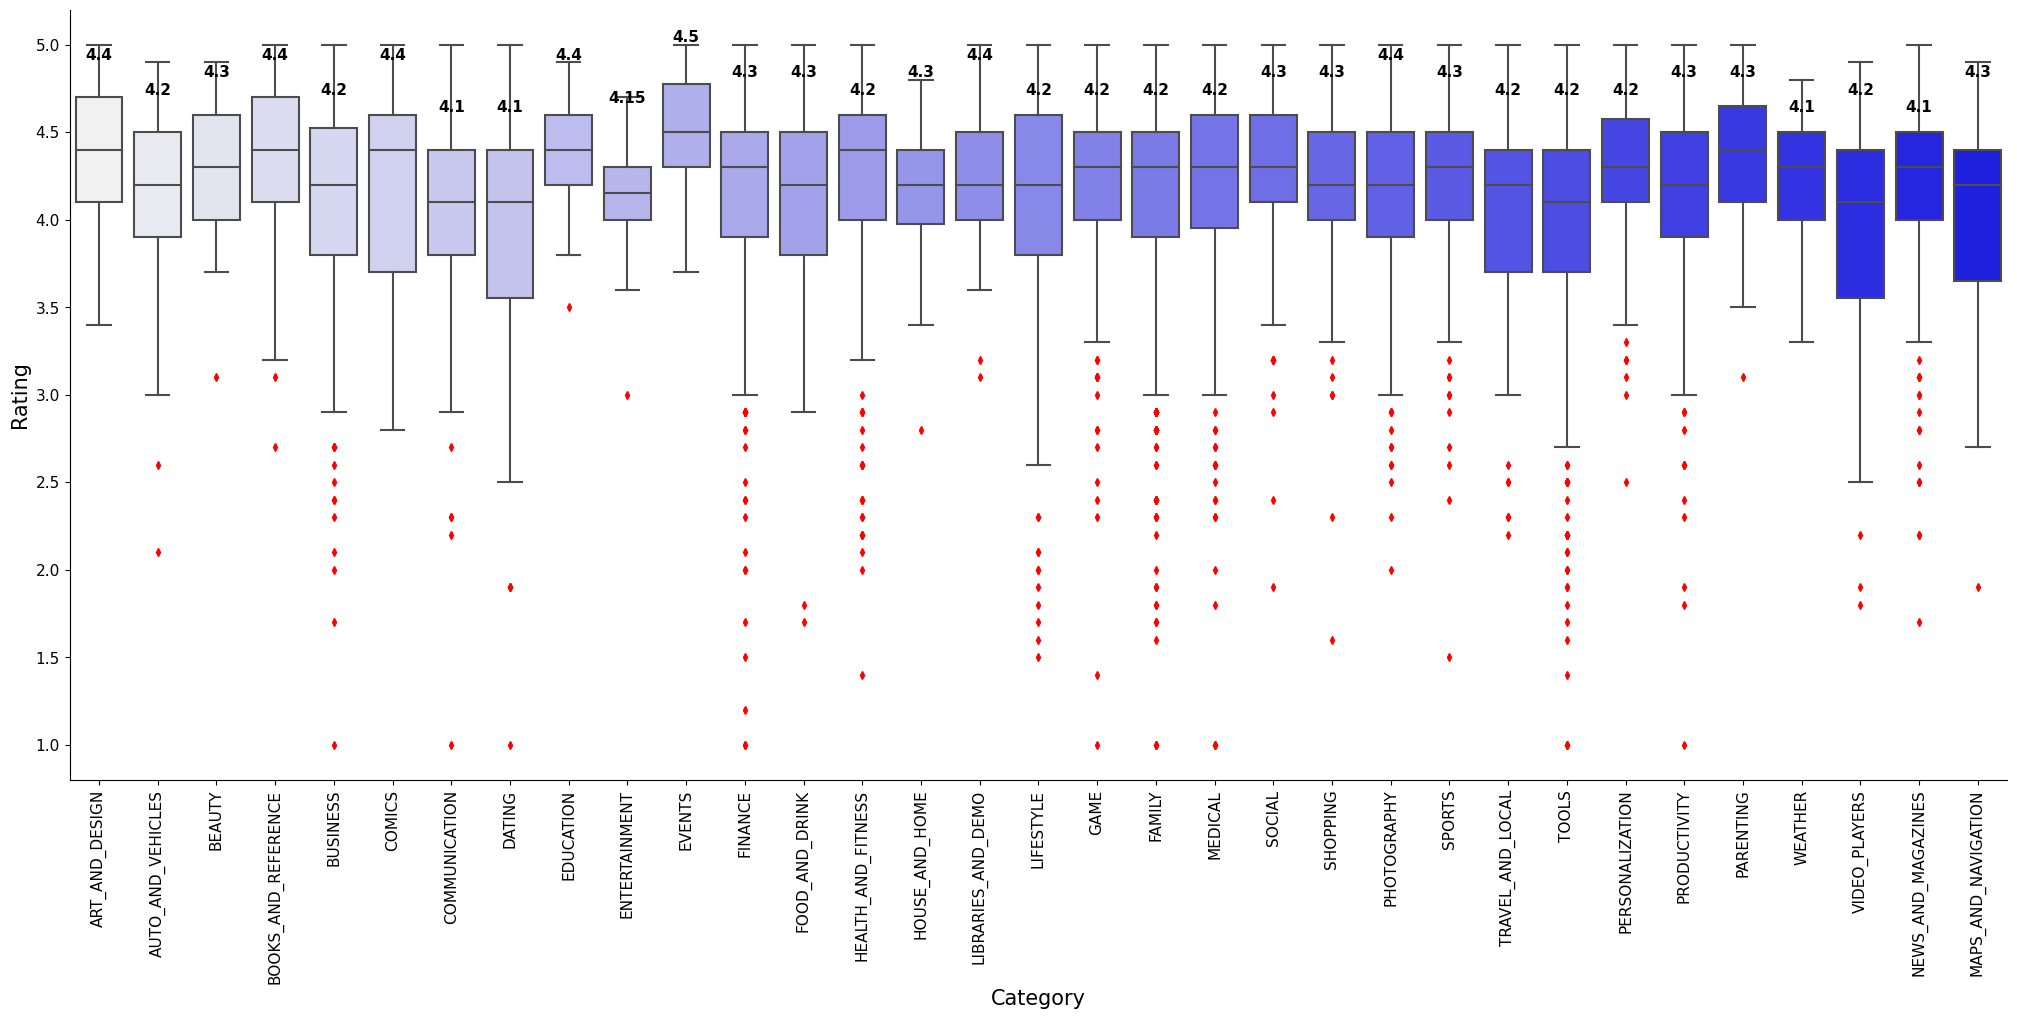

In [88]:
#BoxPlot for Rating vs Category:

plt.figure(figsize=(25,10))

ax=sns.boxplot(data=df_apps, x='Category', y='Rating', orient='v',  palette="light:b", flierprops=flierprops)
plt.xlabel("Category", size=15)
plt.ylabel("Rating", size=15)
ax.tick_params(axis='x', labelsize=11, rotation=90)
ax.tick_params(axis='y', labelsize=11)
sns.despine()

medians = df_apps.groupby(['Category'])['Rating'].median()
vertical_offset = df_apps['Rating'].median() * 0.12 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size=11,color='black',weight='semibold')

plt.show()

In [89]:
y=df_apps['Category'].count()

for i in enumerate(category_var[0:1]):

    print(colored(("Summary Statistics feature - " + i[1] + ":"),'green',attrs=['bold']))
    print("")
    def my_agg(x):
        names = {
            'total_apps'   : x[i[1]].count(),
            '%_of_apps'    : (x[i[1]].count()/y)*100,
            'median_rating'  : x['Rating'].median()
        }
        
        return pd.Series(names, index=['total_apps','%_of_apps','median_rating'])
    stats = df_apps.groupby([i[1]]).apply(my_agg).round(2).sort_values(by=['median_rating'],
                                                                       ascending=False).head(10)

    print(stats)

Summary Statistics feature - Category:

                     total_apps  %_of_apps  median_rating
Category                                                 
EVENTS                    38.00       0.59           4.50
ART_AND_DESIGN            54.00       0.83           4.40
BOOKS_AND_REFERENCE      136.00       2.10           4.40
COMICS                    49.00       0.76           4.40
PARENTING                 43.00       0.66           4.40
EDUCATION                 95.00       1.46           4.40
HEALTH_AND_FITNESS       203.00       3.13           4.40
GAME                     593.00       9.14           4.30
SPORTS                   205.00       3.16           4.30
SOCIAL                   142.00       2.19           4.30


**Rating vs Category Observations:** From the boxplot we can observe that the Events category with a median rating score of 4.5 leads all the other categories in ratings. 

# Data Preprocessing

In [90]:
df_apps.dtypes

Category           object
Rating            float64
Reviews           float64
Installs            int64
Type               object
Price             float64
Content Rating     object
Genres             object
Size              float64
size_groups        object
reviews_groups     object
dtype: object

In [91]:
#Drop the binned group features used in the analysis above, and no longer applicable to analysis next steps
df_apps.drop(['size_groups','reviews_groups'], axis=1, inplace=True)

In [92]:
#Make a copy of the dataframe
inp1 = df_apps.copy()

## Log transformation 

Reviews and Installs have some values that are still relatively high.  Before building a linear regression model,
we need to reduce the skew.

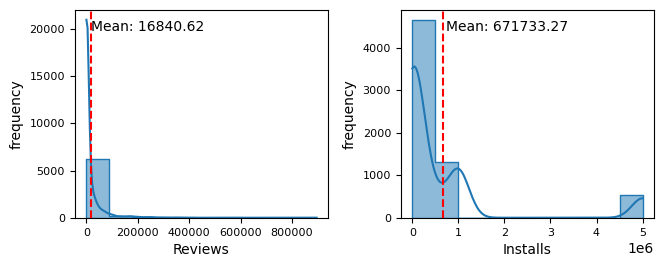

In [93]:
fig=plt.figure(figsize=(10,5))

for i in enumerate(numeric_var[1:3]):
    plt.subplot(2,3,i[0]+1)
    ax=sns.histplot(data=inp1, x=i[1],element='step',palette=['darkseagreen'],bins=10, kde=True)
    plt.xlabel(i[1],  fontsize=10)
    plt.ylabel("frequency", fontsize=10)
    plt.axvline(x=df_apps[i[1]].mean(),ls='--', lw=1.5, c='r')
    plt.setp(ax.get_xticklabels(), fontsize=8)
    plt.setp(ax.get_yticklabels(), fontsize=8)
    min_ylim, max_ylim = plt.ylim()
    plt.text(inp1[i[1]].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(inp1[i[1]].mean()))

plt.tight_layout()
plt.show()

In [94]:
#Apply log transformation (np.log1p) to Reviews and Installs
inp1["Reviews"]=np.log1p(inp1["Reviews"])
inp1["Installs"]=np.log1p(inp1["Installs"])
inp1.head(2)

,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Genres,Size
0,ART_AND_DESIGN,4.10,5.08,9.21,Free,0.00,Everyone,Art & Design,19000.00
1,ART_AND_DESIGN,3.90,6.88,13.12,Free,0.00,Everyone,Art & Design;Pretend Play,14000.00


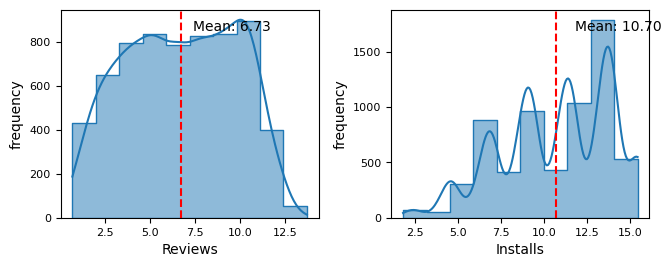

In [95]:
fig=plt.figure(figsize=(10,5))

for i in enumerate(numeric_var[1:3]):
    plt.subplot(2,3,i[0]+1)
    ax=sns.histplot(data=inp1, x=i[1],element='step',palette=['darkseagreen'],bins=10, kde=True)
    plt.xlabel(i[1],  fontsize=10)
    plt.ylabel("frequency", fontsize=10)
    plt.axvline(x=inp1[i[1]].mean(),ls='--', lw=1.5, c='r')
    plt.setp(ax.get_xticklabels(), fontsize=8)
    plt.setp(ax.get_yticklabels(), fontsize=8)
    min_ylim, max_ylim = plt.ylim()
    plt.text(inp1[i[1]].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(inp1[i[1]].mean()))

plt.tight_layout()
plt.show()

## Dummy encoding 

**Dummy encoding:** For our prediction model to execute, all features must be numeric. All categorical features need to be encoded with dummy data. Dummy encoding is one way to convert character fields to numeric. 

In [96]:
inp1.dtypes

Category           object
Rating            float64
Reviews           float64
Installs          float64
Type               object
Price             float64
Content Rating     object
Genres             object
Size              float64
dtype: object

We need to dummy encode the features Category, Type, Content Rating and Genres.

In [97]:
category = ['object']
category_var = []            #initialize 
for each in inp1.columns: #for each column that is object
    if inp1[each].dtypes in category:
        category_var.append(each)

print(category_var)

['Category', 'Type', 'Content Rating', 'Genres']


In [98]:
inp2=pd.get_dummies(inp1, columns = category_var, drop_first=True)
inp2.head(2)

,Rating,Reviews,Installs,Price,Size,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,...,Genres_Strategy;Education,Genres_Tools,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
0,4.10,5.08,9.21,0.00,19000.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.90,6.88,13.12,0.00,14000.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model building 

**Using Linear Regression to predict an outcome for rating**

In [99]:
inp2.head()

,Rating,Reviews,Installs,Price,Size,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,...,Genres_Strategy;Education,Genres_Tools,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
0,4.10,5.08,9.21,0.00,19000.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.90,6.88,13.12,0.00,14000.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.70,11.38,15.42,0.00,8700.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.30,6.88,11.51,0.00,2800.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4.40,5.12,10.82,0.00,5600.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# spliting data from target
X = inp2.drop(['Rating'], axis=1).values #data of independent var. Excludes the target, dependent variable, "Rating".
y = inp2['Rating'].values                #independent variable data
print ('Shape of X :', X.shape)
print ('Shape of y :', y.shape)

Shape of X : (6489, 149)
Shape of y : (6489,)


In [101]:
print(X)

[[ 5.07517382  9.21044037  0.         ...  0.          0.
   0.        ]
 [ 6.87523209 13.12236538  0.         ...  0.          0.
   0.        ]
 [11.37951978 15.42494867  0.         ...  0.          0.
   0.        ]
 ...
 [ 2.07944154  6.2166061   0.         ...  0.          0.
   0.        ]
 [ 3.66356165  8.51739317  0.         ...  0.          0.
   0.        ]
 [ 1.60943791  4.61512052  0.         ...  0.          0.
   0.        ]]


In [102]:
print(y)

[4.1 3.9 4.7 ... 4.  4.5 5. ]


In [103]:
#split training vs testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=20)

In [104]:
# define and configure the model
lm_model = LinearRegression()

#train the model using training data; X contains the predictor features,y contains the target (predicted value)
lm_model.fit(X_train, y_train)

LinearRegression()

In [105]:
#predict a response (target outcome) to the X_test data
y_pred = lm_model.predict(X_test)
y_pred = y_pred.round(decimals=1)
print(y_pred)

[4.4 4.  4.  ... 3.8 3.7 4.5]


**Compare Actual Rating vs. Predicted Rating**

**Row 1 of inp2**

In [106]:
row_1_x = inp2[:1]
row_1_x = row_1_x.drop(["Rating"], axis=1)
row_1_x = row_1_x.values

In [107]:
row_1_y = inp2[0:1]
row_1_y = row_1_y.Rating.values

In [108]:
#Using the X values from the 1st row of dataframe (inp2) we will compare the predicted value vs. the actual value
Predicated_Value_row_1_x = lm_model.predict(row_1_x)

print("Actual Rating for the 1st row in our dataframe inp2: ", row_1_y)
print("Predicted Rating for the 1st row in our dataframe inp2: ", Predicated_Value_row_1_x.round(decimals=1))

Actual Rating for the 1st row in our dataframe inp2:  [4.1]
Predicted Rating for the 1st row in our dataframe inp2:  [4.4]


**Row 2 of inp2**

In [109]:
row_2_x = inp2[1:2]
row_2_x = row_2_x.drop(["Rating"], axis=1)
row_2_x = row_2_x.values

In [110]:
row_2_y = inp2[1:2]
row_2_y = row_2_y.Rating.values

In [111]:
#Using the X values from the 1st row of dataframe (inp2) we will compare the predicted value vs. the actual value
Predicated_Value_row_2_x = lm_model.predict(row_2_x)

print("Actual Rating for the 2nd row in our dataframe inp2: ", row_2_y)
print("Predicted Rating for the 2nd row in our dataframe inp2: ", Predicated_Value_row_2_x.round(decimals=1))

Actual Rating for the 2nd row in our dataframe inp2:  [3.9]
Predicted Rating for the 2nd row in our dataframe inp2:  [3.9]


## Evaluate Model - R2 score

In [112]:
r2score = r2_score(y_test, y_pred)
r2score =r2score*100
print("The prediction models r2 score is: ", r2score.round(decimals=2))

The prediction models r2 score is:  13.06


**Observation:** Approximately 13.1% of the variation in Rating Score can be explained by the independent ("predictor") variables found in our data.

## Visualize Predicted Results

In [113]:
pred_y_df = pd.DataFrame({"Actual Rating":y_test, "Predicted Rating":y_pred, "Delta":y_pred - y_test})
pred_y_df.head(5)

,Actual Rating,Predicted Rating,Delta
0,4.30,4.40,0.10
1,4.30,4.00,-0.30
2,3.10,4.00,0.90
3,3.30,3.90,0.60
4,4.20,4.00,-0.20


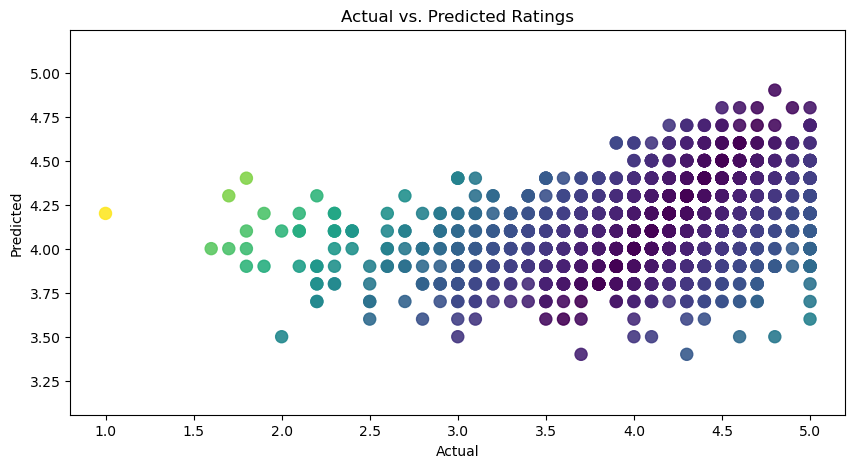

In [114]:
plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred, c=abs(y_pred-y_test), s = 75, alpha=.9)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Ratings")
plt.axis("equal")

plt.show()

**Observations:** In the scatter plot above, the weaker (lighter) colors represent the Ratings which had the larger difference in Predicted Rating vs. Actual Rating.  We can note that Actual Ratings that were less than 3.0 were more likely to receive a higher predicted rating score when compared to the actual score. 